## Imports and Helpers

In [1]:
import torch
import torch.utils.data
from torch.nn import functional as F
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image

from fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from pathlib import Path
import pdb
import cv2

import imageio

%matplotlib inline

In [2]:
class VAEVizHelper:
    def __init__(self, recon_base_imgs, n=20, recon_tracking=True, datagen_tracking=True):
        
        self.recon_tracking = recon_tracking
        self.datagen_tracking = datagen_tracking
        
        # base image (top row, stitched together)
        self.recon_base_img = np.concatenate([np.squeeze(x) for x in recon_base_imgs], axis=1)
        # base images (separate, not stitched together)
        self.recon_base_imgs = recon_base_imgs
        
        # placeholders for the reconstruction and data generation
        # images that will be used to create gifs
        self.recon_tracking_imgs = []
        self.datagen_tracking_imgs = []
        
        # linearly spaced coordinates on the unit square were transformed through 
        # the inverse CDF of the Gaussian to produce values of the latent variables z
        self.grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
        self.grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
        # how many points to sample along the latent space
        self.n = n
        
    def execute(self, model):
        if self.recon_tracking:
            # handle reconstruction figures
            recon_figure = self.create_recon_figure(model)
            self.recon_tracking_imgs.append(recon_figure)
        if self.datagen_tracking:
            # handle data generation figures
            datagen_figure = self.create_datagen_figure(model)
            self.datagen_tracking_imgs.append(datagen_figure)
        
    def create_recon_figure(self, model):
        """
        Returns an image with the real MNIST images on the top row and
        the corresponding reconstructed images on the bottom row. These
        images can be used to visualize how well the VAE is able to
        reconstruct its input data at various points during training.
        """
        recon_imgs = []
        for img in self.recon_base_imgs:
            recon = model(img)[0].view(28,28).detach().numpy()
            recon_imgs.append(recon)
        tmp = np.concatenate(recon_imgs, axis=1)
        figure = np.concatenate([self.recon_base_img, tmp], axis=0)
        figure = (figure * 255.).astype('uint8')
        return figure
    
    def create_datagen_figure(self, model):
        """
        Returns an image of digits generated across the manifold of 
        the latent space.
        """
        figure = np.zeros((28*self.n, 28*self.n))
        for i, yi in enumerate(self.grid_x):
            for j, xi in enumerate(self.grid_y):
                z_sample = torch.tensor([[xi, yi]])
                x_decoded = model.decode(z_sample)
                digit = x_decoded.view(28,28).detach().numpy()
                figure[i * 28: (i + 1) * 28,
                       j * 28: (j + 1) * 28] = digit
        figure = (figure * 255.).astype('uint8')
        return figure

In [3]:
batch_size = 128
epochs = 10
seed = 199
log_interval=10
device='cpu'

torch.manual_seed(seed)
np.random.seed(seed)

## Load and Prep Data

In [4]:
xforms = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x.round()
])

ds = datasets.MNIST('../data', train=False, transform=xforms, download=True)
recon_base_imgs = []
for i in [1, 4, 12, 15, 22]:
    img = ds[i][0]
    recon_base_imgs.append(img)
recon_base_img = np.concatenate([np.squeeze(x.numpy()) for x in recon_base_imgs], axis=1)
del ds

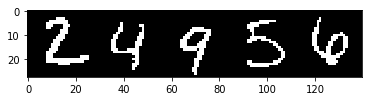

In [5]:
fig, ax = plt.subplots()
ax.imshow(recon_base_img, cmap='gray', interpolation='none')
plt.show()

In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=xforms),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=xforms),
    batch_size=batch_size, shuffle=True)

In [7]:
len(train_loader.dataset), len(test_loader.dataset)

(60000, 10000)

## Define Model and Training Functions

In [8]:
class VAE(nn.Module):
    def __init__(self, data_size=784, encoder_szs=[400, 2], 
                 decoder_szs=None):
        super(VAE, self).__init__()
        
        # if decoder_szs not specified, assume symmetry
        if decoder_szs is None:
            decoder_szs = encoder_szs[::-1]
        
        # construct the encoder
        encoder_szs = [data_size] + encoder_szs
        encoder_layers = []
        for in_sz, out_sz in zip(encoder_szs[:-2], encoder_szs[1:-1]):
            encoder_layers.append(nn.Linear(in_sz, out_sz))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
        self.encoder_mu = nn.Linear(encoder_szs[-2], encoder_szs[-1])
        self.encoder_logvar = nn.Linear(encoder_szs[-2], encoder_szs[-1])
        
        # construct the decoder
        decoder_layers = []
        for in_sz, out_sz in zip(decoder_szs[:-1], decoder_szs[1:]):
            decoder_layers.append(nn.Linear(in_sz, out_sz))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(decoder_szs[-1], data_size))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.data_size = data_size

    def encode(self, x):
        h = self.encoder(x)
        return self.encoder_mu(h), self.encoder_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.data_size))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [9]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [10]:
p = torch.tensor(np.random.rand(128, 784))
x = torch.tensor(np.random.rand(128, 784).round())

In [11]:
p.shape, x.shape

(torch.Size([128, 784]), torch.Size([128, 784]))

In [12]:
F.binary_cross_entropy(p, x, reduction='sum')

tensor(100392.3963, dtype=torch.float64)

In [13]:
bces = []
for i in range(128):
    bce = F.binary_cross_entropy(p[i,:], x[i,:], reduction='sum')
    bces.append(bce)

In [14]:
sum(bces)

tensor(100392.3963, dtype=torch.float64)

In [15]:
def train(epoch, mb, figure_interval, viz_helper):
    model.train()
    train_loss = 0
    pb = progress_bar(train_loader, parent=mb)
    for batch_idx, (data, _) in enumerate(pb):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % figure_interval == 0:
            viz_helper.execute(model)

    return train_loss / len(train_loader.dataset)

In [16]:
def test(epoch, mb):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        pb = progress_bar(test_loader, parent=mb)
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    return test_loss / len(test_loader.dataset)

In [17]:
def fit(model, epochs, figure_interval, viz_helper):
    mb = master_bar(range(1, epochs + 1))
    viz_helper.execute(model)
    for epoch in mb:
        trn_loss = train(epoch, mb, figure_interval=10, viz_helper=viz_helper)
        tst_loss = test(epoch, mb)
        mb.write(f'epoch {epoch}, train loss: {round(trn_loss,6)}, test loss: {round(tst_loss, 6)}')                                                                  


## VAE with 20-d Latent Space

Use this one to generate reconstruction figures.

In [18]:
viz_helper_20d = VAEVizHelper(recon_base_imgs, datagen_tracking=False)

In [19]:
model = VAE(encoder_szs=[400,20]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [20]:
model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
  )
  (encoder_mu): Linear(in_features=400, out_features=20, bias=True)
  (encoder_logvar): Linear(in_features=400, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [21]:
fit(model, 10, 10, viz_helper_20d)

In [ ]:
imageio.mimsave('~/git/acetherace.github.io/images/vae/recon_tracking.gif', 
                viz_helper_20d.recon_tracking_imgs[::5], duration=.05)

In [ ]:
imageio.mimsave('~/git/acetherace.github.io/images/vae/recon_tracking_early.gif',
                viz_helper_20d.recon_tracking_imgs[:150:1], duration=.1)

### Anomaly detection

In [41]:
# anomaly = imageio.imread('~/git/acetherace.github.io/images/vae/mario.png', as_gray=True)
# anomaly = cv2.resize(anomaly, dsize=(28,28))
# anomaly /= 255
# anomaly = (anomaly > 0.5).astype('int')
# anomaly = 1 - anomaly

In [50]:
anomaly = np.random.randint(low=0, high=2, size=(28,28))

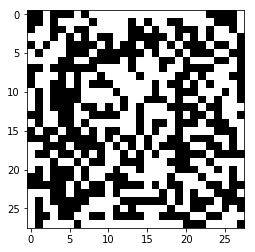

In [52]:
plt.imshow(anomaly, cmap='gray')

In [51]:
anomaly.shape

(28, 28)

In [44]:
def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

In [30]:
kls = []
for i in range(len(train_loader.dataset)):
    x, _ = train_loader.dataset[i]
    _, mu, logvar = model(x)
    kls.append(kl_divergence(mu, logvar).item())

In [31]:
kls = np.asarray(kls)

In [32]:
kls[:5]

array([33.08784485, 29.66623306, 30.39261627, 19.6877594 , 29.83441544])

In [34]:
kls.shape

(60000,)

In [35]:
import seaborn as sns

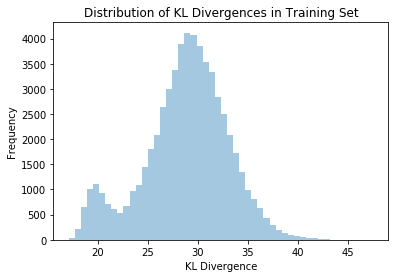

In [55]:
fig, ax = plt.subplots()
sns.distplot(kls, kde=False, ax=ax)
ax.set_title('Distribution of KL Divergences in Training Set')
ax.set_xlabel('KL Divergence')
ax.set_ylabel('Frequency')
plt.show()

In [56]:
_, mu, logvar = model(torch.tensor(anomaly).type(torch.FloatTensor))
kl_divergence(mu, logvar).item()

51.76375198364258

In [108]:
mu, std = norm.fit(kl_divs)

In [109]:
mu, std

(28.801664, 4.2350025)

## VAE with 2-d Latent Space

Use this one to generate data generation figures.

In [26]:
viz_helper_2d = VAEVizHelper(recon_base_imgs)

In [27]:
model = VAE(encoder_szs=[400,150,2]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [28]:
model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=150, bias=True)
    (3): ReLU()
  )
  (encoder_mu): Linear(in_features=150, out_features=2, bias=True)
  (encoder_logvar): Linear(in_features=150, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=150, bias=True)
    (1): ReLU()
    (2): Linear(in_features=150, out_features=400, bias=True)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [29]:
fit(model, 10, 10, viz_helper_2d)

In [30]:
imageio.mimsave('~/git/acetherace.github.io/images/vae/datagen_tracking.gif', 
                viz_helper_2d.datagen_tracking_imgs[::5], duration=.05)

In [31]:
imageio.mimsave('~/git/acetherace.github.io/images/vae/datagen_tracking_early.gif',
                viz_helper_2d.datagen_tracking_imgs[:200:2], duration=.1)

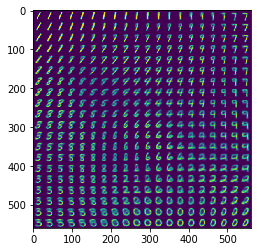

In [32]:
plt.imshow(viz_helper_2d.datagen_tracking_imgs[-1])

In [33]:
import scipy.misc

In [34]:
imageio.imwrite('~/git/acetherace.github.io/images/vae/datagen_final.png', 
                viz_helper_2d.datagen_tracking_imgs[-1])